In [1]:
import wandb
import pandas
import numpy as np
import matplotlib.pyplot as plt
api = wandb.Api()


In [2]:
runs = api.runs("saleml/continuous_gflownets")
interesting_runs = []

for run in runs:
    if (run.config['seed'] in (111, 112, 113)
        and (
            (run.config['loss'] == 'tb' and run.config['lr_Z'] == 0.001 ) or
            (run.config['loss'] == 'db' and run.config['lr_Z'] == 0.001 )
            )
    ):
        values = run.history()['JSD'].values
        if len(values[~np.isnan(values)]) == 39:
            interesting_runs.append(run)




In [3]:
values = interesting_runs[10].history()['JSD'].values
steps = interesting_runs[10].history()['states_visited'].values
steps = steps[~np.isnan(values)]

In [4]:
len(values[~np.isnan(values)])

39

In [10]:
groups = {}

for loss in ['tb', 'db']:
    for PB in ['uniform', 'tied']:
        for delta in [0.25, 0.1]:
            for gamma, milestone in [(0.5, 2500), (0.1, 5000)]:
                group_name = f"{delta}_{loss}_{PB}_{gamma}_{milestone}"
                groups[group_name] = []
                for seed in [111, 112, 113]:
                    for run in interesting_runs:
                        if (run.config['loss'] == loss and run.config['PB'] == PB and run.config['delta'] == delta
                         and run.config['gamma_scheduler'] == gamma and run.config['scheduler_milestone'] == milestone
                          and run.config['seed'] == seed):
                            jsd_values = run.history()['JSD'].values
                            jsd_values = jsd_values[~np.isnan(jsd_values)]
                            groups[group_name].append(jsd_values)

In [11]:
len(groups)

16

In [12]:
[len(v) for v in groups.values()]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [13]:
averages = {}
stds = {}
for group_name, group in groups.items():
    averages[group_name] = np.mean(group, axis=0)
    stds[group_name] = np.std(group, axis=0)

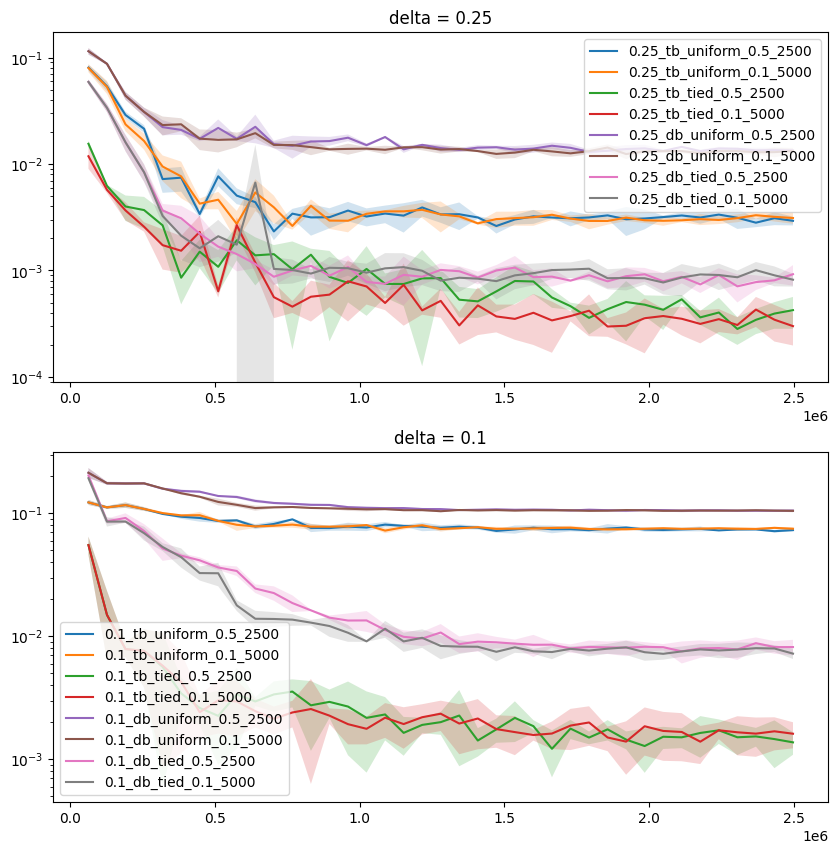

In [15]:
# Plot the averages and stds for each group against the steps array
# logaritmic scale for the y axis
# One plot for when delta = 0.25 and one for when delta = 0.1
# Use solid lines for when loss = tb and dashed lines for when loss = db

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for i, delta in enumerate([0.25, 0.1]):
    for j, loss in enumerate(['tb', 'db', 'modifieddb']):
        for k, PB in enumerate(['uniform', 'tied']):
            for gamma, milestone in [(0.5, 2500), (0.1, 5000)]:
                group_name = f"{delta}_{loss}_{PB}_{gamma}_{milestone}"
                if group_name in averages.keys() and (averages[group_name]).shape != ():
                    axes[i].plot(steps, averages[group_name], label=group_name)
                    axes[i].fill_between(steps, averages[group_name] - stds[group_name], averages[group_name] + stds[group_name], alpha=0.2)
    axes[i].set_title(f"delta = {delta}")
    axes[i].set_yscale('log')
    axes[i].legend()    


plt.show()


In [17]:
# Now do the same, but first, group only by delta, loss, PB (i.e. average over gamma and milestone)
# Only select runs where [(0.5, 2500), (0.1, 5000)] are used for  gamma and milestone when creating the groups

groups = {}

for loss in ['tb', 'db']:
    for PB in ['uniform', 'tied']:
        for delta in [0.25, 0.1]:
            group_name = f"{delta}_{loss}_{PB}"
            groups[group_name] = []
            for seed in [111, 112, 113]:
                for run in interesting_runs:
                    if (run.config['loss'] == loss and run.config['PB'] == PB and run.config['delta'] == delta
                     and run.config['seed'] == seed
                     and (run.config['gamma_scheduler'], run.config['scheduler_milestone']) in [(0.5, 2500), (0.1, 5000)]
                     ):
                        jsd_values = run.history()['JSD'].values
                        jsd_values = jsd_values[~np.isnan(jsd_values)]
                        groups[group_name].append(jsd_values)




In [21]:
averages = {}
stds = {}
for group_name, group in groups.items():
    averages[group_name] = np.mean(group, axis=0)
    stds[group_name] = np.std(group, axis=0)

In [22]:
# Smoothen the averages and stds by convolving with a gaussian kernel
# clip the values of the std to be at most 0.01

from scipy.ndimage import gaussian_filter1d

averages_smooth = {}
stds_smooth = {}
for group_name, group in groups.items():
    averages_smooth[group_name] = gaussian_filter1d(averages[group_name], sigma=1)
    stds_smooth[group_name] = gaussian_filter1d(stds[group_name], sigma=1)
    stds_smooth[group_name] = np.clip(stds_smooth[group_name], 0, 0.001)


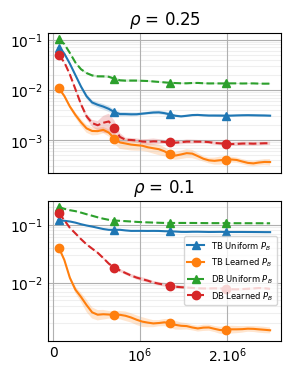

In [20]:
# The following comments is me giving orders to github copilot

# Plot the averages and stds for each group against the steps array
# logaritmic scale for the y axis
# One plot for when delta = 0.25 and one for when delta = 0.1
# Use solid lines for when loss = tb and dashed lines for when loss = db
# Add a grid to the plots
# Use triangles for when PB = uniform with spaced out markers

fig, axes = plt.subplots(2, 1, figsize=(3, 4))
for i, delta in enumerate([0.25, 0.1]):
    for j, loss in enumerate(['tb', 'db']):
        for k, PB in enumerate(['uniform', 'tied']):
            group_name = f"{delta}_{loss}_{PB}"
            axes[i].plot(steps, averages_smooth[group_name],
             label=f"{group_name.split('_')[1].upper()}"+(r" Uniform $P_B$ " if PB == 'uniform' else r' Learned $P_B$'),
             linestyle='--' if loss == 'db' else '-', marker='^' if PB == 'uniform' else 'o', markevery=10)
            axes[i].fill_between(steps, averages_smooth[group_name] - stds_smooth[group_name], averages_smooth[group_name] + stds_smooth[group_name], alpha=0.2)
    axes[i].set_title(fr"$\rho$ = {delta}")
    axes[i].set_yscale('log')
    axes[i].grid()

# Keep the ticks but remove the tick labels from the top plot's x axis
axes[0].set_xticklabels([])
# Shorten the size of the x ticks for the top plot
axes[0].tick_params(axis='x', which='both', length=0)
axes[1].tick_params(axis='x', which='both', length=0)

# Shorten the size of the y ticks for both plots
axes[0].tick_params(axis='y', which='both', length=0)
axes[1].tick_params(axis='y', which='both', length=0)

# Add a legend to the bottom plot
axes[1].legend()
# Make the legend a bit smaller
axes[1].legend(fontsize=6)

# Add more transparent grid on the minor ticks for both plots
axes[0].grid(which='minor', alpha=0.2)
axes[1].grid(which='minor', alpha=0.2)

# Change the x tick labels for the bottom plot
axes[1].set_xticks([0, 1e6, 2e6])
axes[1].set_xticklabels([0, r'$10^6$', r'$2 . 10^6$'])

# Save figure to pdf with tight layout
plt.savefig('grid_jsd.pdf', bbox_inches='tight')

plt.show()




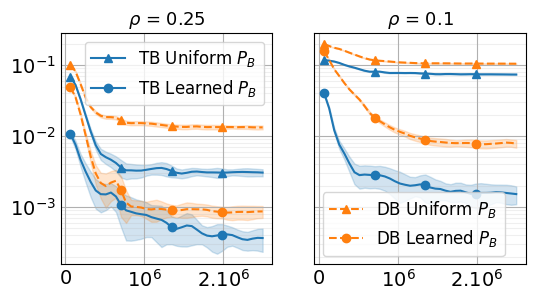

In [51]:

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
# Share y axis
for i, delta in enumerate([0.25, 0.1]):
    for j, loss in enumerate(['tb', 'db']):
        for k, PB in enumerate(['uniform', 'tied']):
            group_name = f"{delta}_{loss}_{PB}"
            if delta == 0.25 and loss == 'db':
                label = None
            elif delta == 0.1 and loss == 'tb':
                label = None
            else:
                label = f"{group_name.split('_')[1].upper()}"+(r" Uniform $P_B$ " if PB == 'uniform' else r' Learned $P_B$')

            
            axes[i].plot(steps, averages_smooth[group_name],
                label=label,
                linestyle='--' if loss == 'db' else '-', marker='^' if PB == 'uniform' else 'o', markevery=10,
                color='C0' if loss == 'tb' else 'C1'
                )

            axes[i].fill_between(steps, averages_smooth[group_name] - stds_smooth[group_name], averages_smooth[group_name] + stds_smooth[group_name], alpha=0.2,
            color='C0' if loss == 'tb' else 'C1')
    axes[i].set_title(fr"$\rho$ = {delta}", fontsize=13)
    axes[i].set_yscale('log')
    axes[i].grid()

# Share the y axis between the two plots
# axes[0].get_shared_y_axes().join(axes[0], axes[1])


axes[0].tick_params(axis='x', which='both', length=0)
axes[1].tick_params(axis='x', which='both', length=0)

axes[0].tick_params(axis='y', which='both', length=0)
axes[1].tick_params(axis='y', which='both', length=0)

axes[0].legend()
axes[0].legend(fontsize=12)

axes[1].legend()
axes[1].legend(fontsize=12)


axes[0].grid(which='minor', alpha=0.2)
axes[1].grid(which='minor', alpha=0.2)

axes[1].set_xticks([0, 1e6, 2e6])
axes[1].set_xticklabels([0, r'$10^6$', r'$2 . 10^6$'])

axes[0].set_xticks([0, 1e6, 2e6])
axes[0].set_xticklabels([0, r'$10^6$', r'$2 . 10^6$'])

# Increase font of the x and y axis tick labels
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

# Save figure to pdf with tight layout
plt.savefig('grid_jsd_horizontal.pdf', bbox_inches='tight')

plt.show()


